Hedef değişken : "Outcome" diabet mi (1), değil mi (0) sorusunu cevaplar.

Problemimiz bir sınıflandırma problemidir.


In [128]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)

In [129]:
df = pd.read_csv("/content/diabetes.csv")

In [130]:
#Genel resmi inceleme
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

check_df(df)

##################### Shape #####################
(768, 9)
##################### Types #####################
Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object
##################### Head #####################
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin    BMI  DiabetesPedigreeFunction  Age  Outcome
0            6      148             72             35        0 33.600                     0.627   50        1
1            1       85             66             29        0 26.600                     0.351   31        0
2            8      183             64              0        0 23.300                     0.672   32        1
3            1       89             66             23       94 2

In [131]:
#Numerik ve kategorik değişkenleri yakalamak
# Grab_col_names fonksiyonu numerik ve kategorik değişkenlerin tespiti için kullanılır.
def grab_col_names(dataframe, cat_th=10,car_th=20):
  ####### -- kategorik değişkenler
  cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
  ####### -- numerik ama kategorik değişkenler
  num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
  ####### -- kategorik ama kardinaritesi yüksek olan değişkenler
  cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
  cat_cols = cat_cols + num_but_cat
  cat_cols = [col for col in cat_cols if col not in cat_but_car]
  #numerik değişkenler
  num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
  num_cols = [col for col in num_cols if col not in num_but_cat]

  print(f"Observations: {dataframe.shape[0]}")
  print(f"Variables: {dataframe.shape[1]}")
  print(f'cat_cols: {len(cat_cols)}')
  print(f'num_cols: {len(num_cols)}')
  print(f'cat_but_car: {len(cat_but_car)}')
  print(f'num_but_cat: {len(num_but_cat)}')
  return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 768
Variables: 9
cat_cols: 1
num_cols: 8
cat_but_car: 0
num_but_cat: 1


         Outcome  Ratio
Outcome                
0            500 65.104
1            268 34.896
##########################################


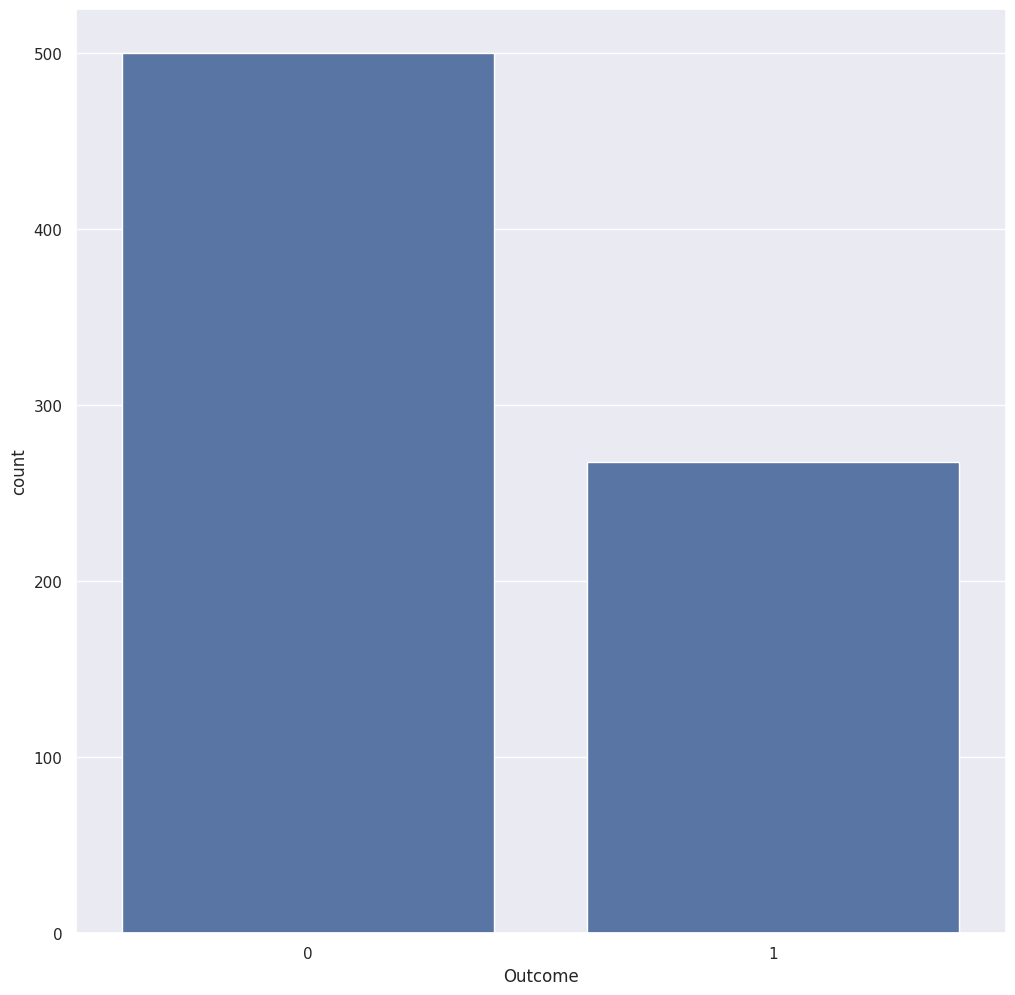

In [132]:
#Kategorik değişkenlerin analizi
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")

    if plot:
     sns.countplot(x=dataframe[col_name], data=dataframe)
     plt.show(block=True)

cat_summary(df, "Outcome", plot=True)

count   768.000
mean      3.845
std       3.370
min       0.000
5%        0.000
10%       0.000
20%       1.000
30%       1.000
40%       2.000
50%       3.000
60%       4.000
70%       5.000
80%       7.000
90%       9.000
95%      10.000
99%      13.000
max      17.000
Name: Pregnancies, dtype: float64


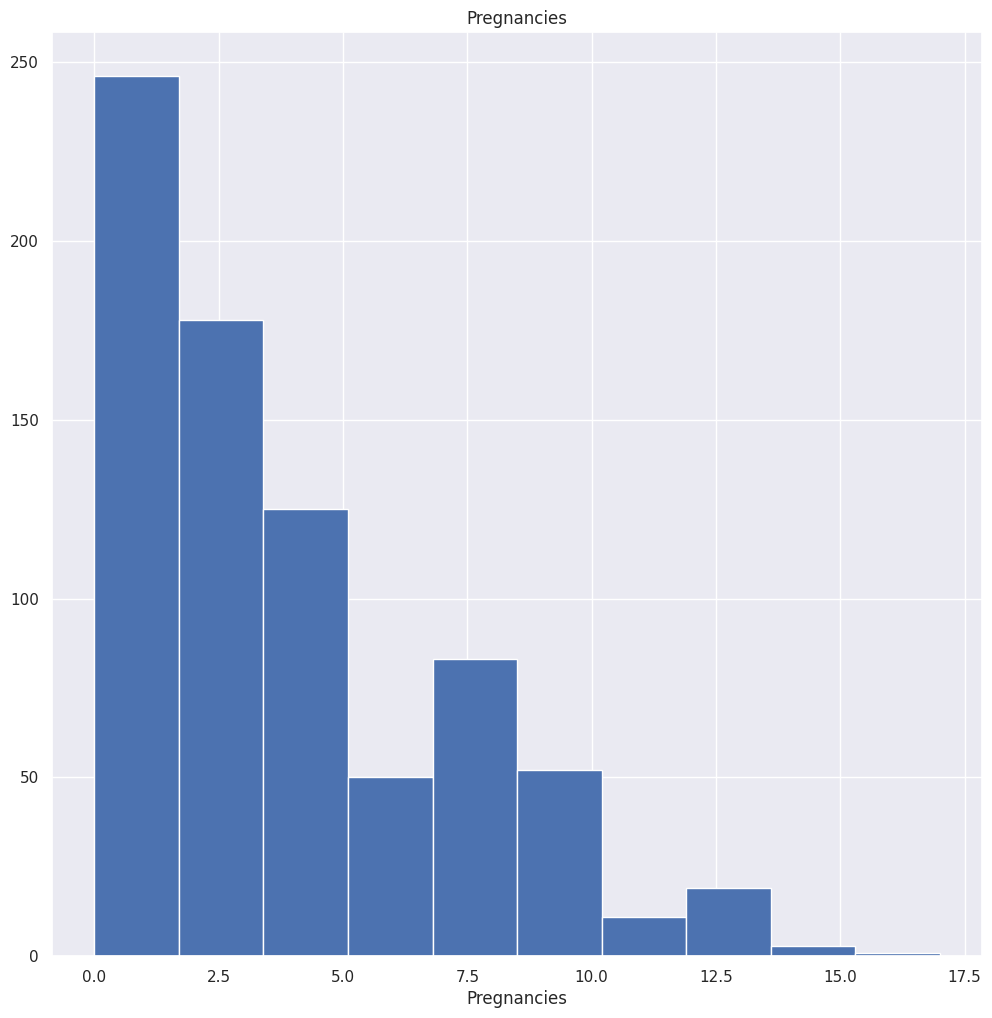

count   768.000
mean    120.895
std      31.973
min       0.000
5%       79.000
10%      85.000
20%      95.000
30%     102.000
40%     109.000
50%     117.000
60%     125.000
70%     134.000
80%     147.000
90%     167.000
95%     181.000
99%     196.000
max     199.000
Name: Glucose, dtype: float64


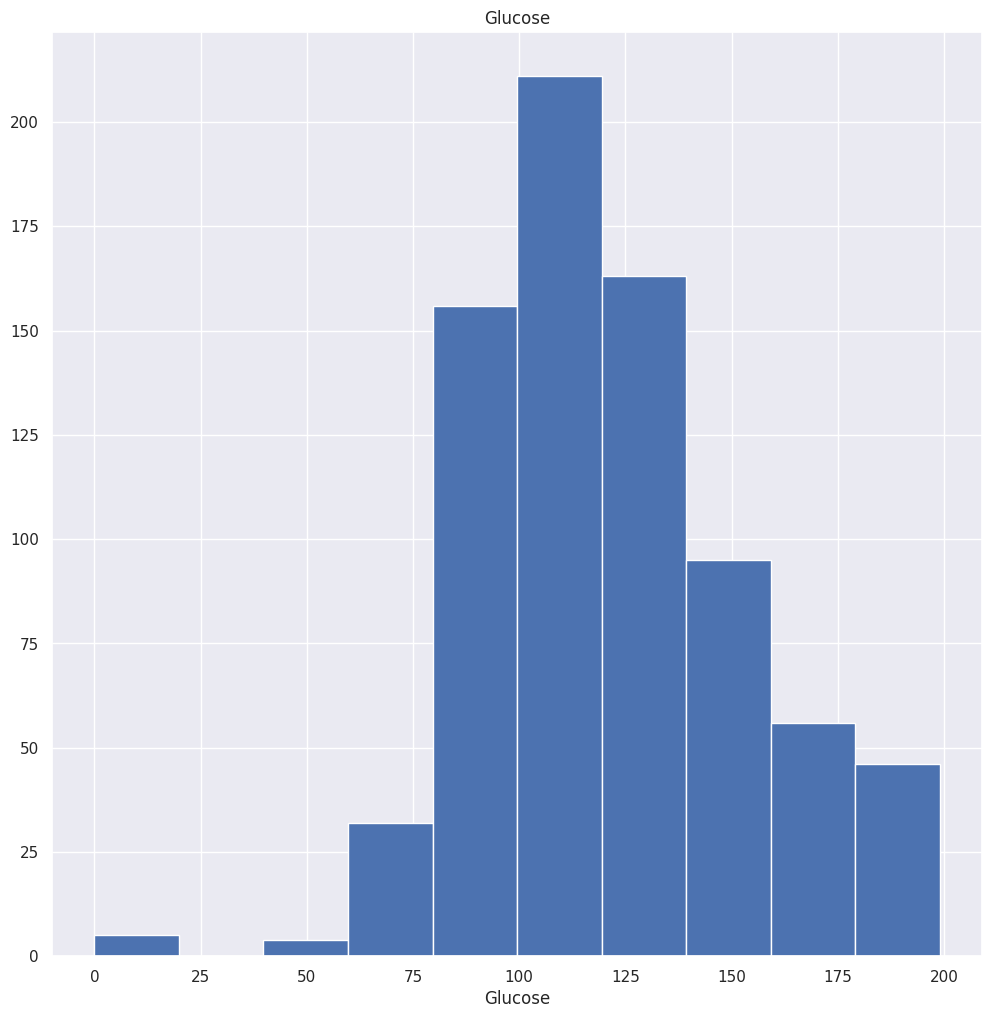

count   768.000
mean     69.105
std      19.356
min       0.000
5%       38.700
10%      54.000
20%      60.000
30%      64.000
40%      68.000
50%      72.000
60%      74.000
70%      78.000
80%      82.000
90%      88.000
95%      90.000
99%     106.000
max     122.000
Name: BloodPressure, dtype: float64


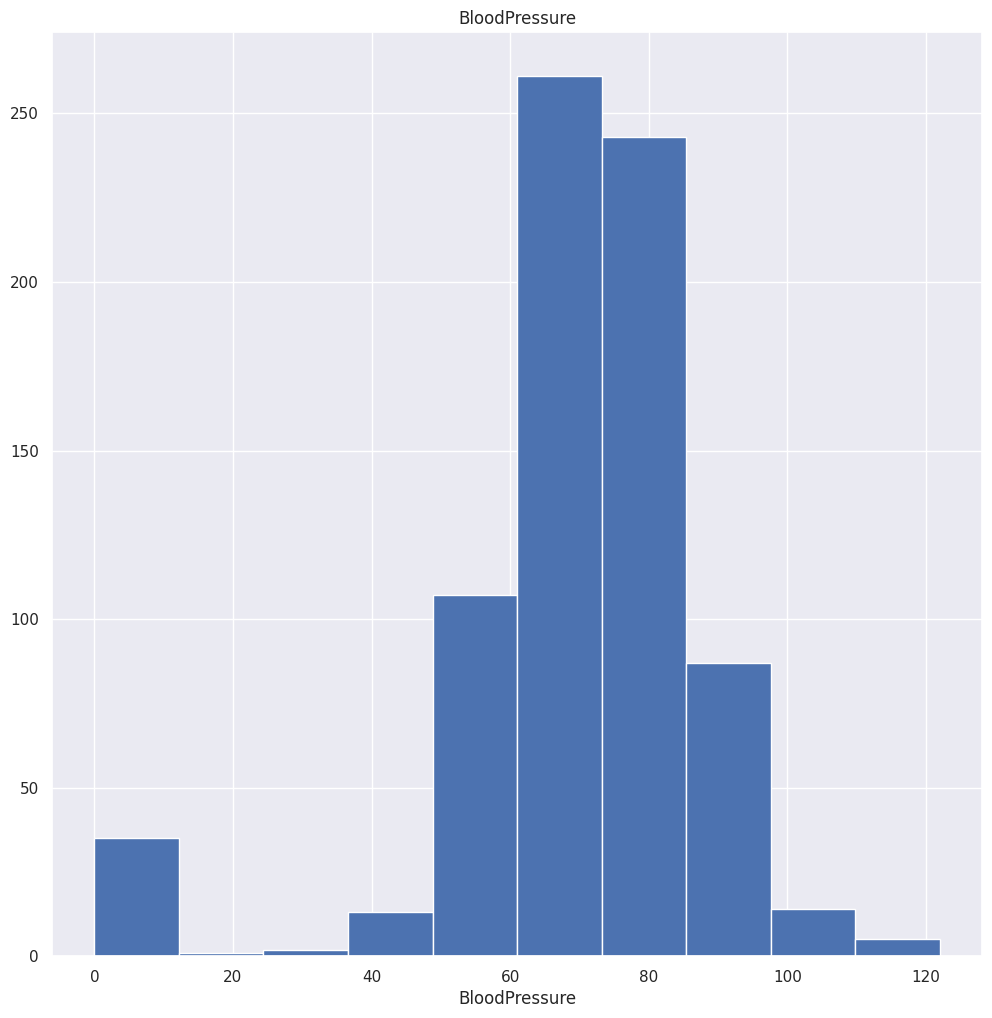

count   768.000
mean     20.536
std      15.952
min       0.000
5%        0.000
10%       0.000
20%       0.000
30%       8.200
40%      18.000
50%      23.000
60%      27.000
70%      31.000
80%      35.000
90%      40.000
95%      44.000
99%      51.330
max      99.000
Name: SkinThickness, dtype: float64


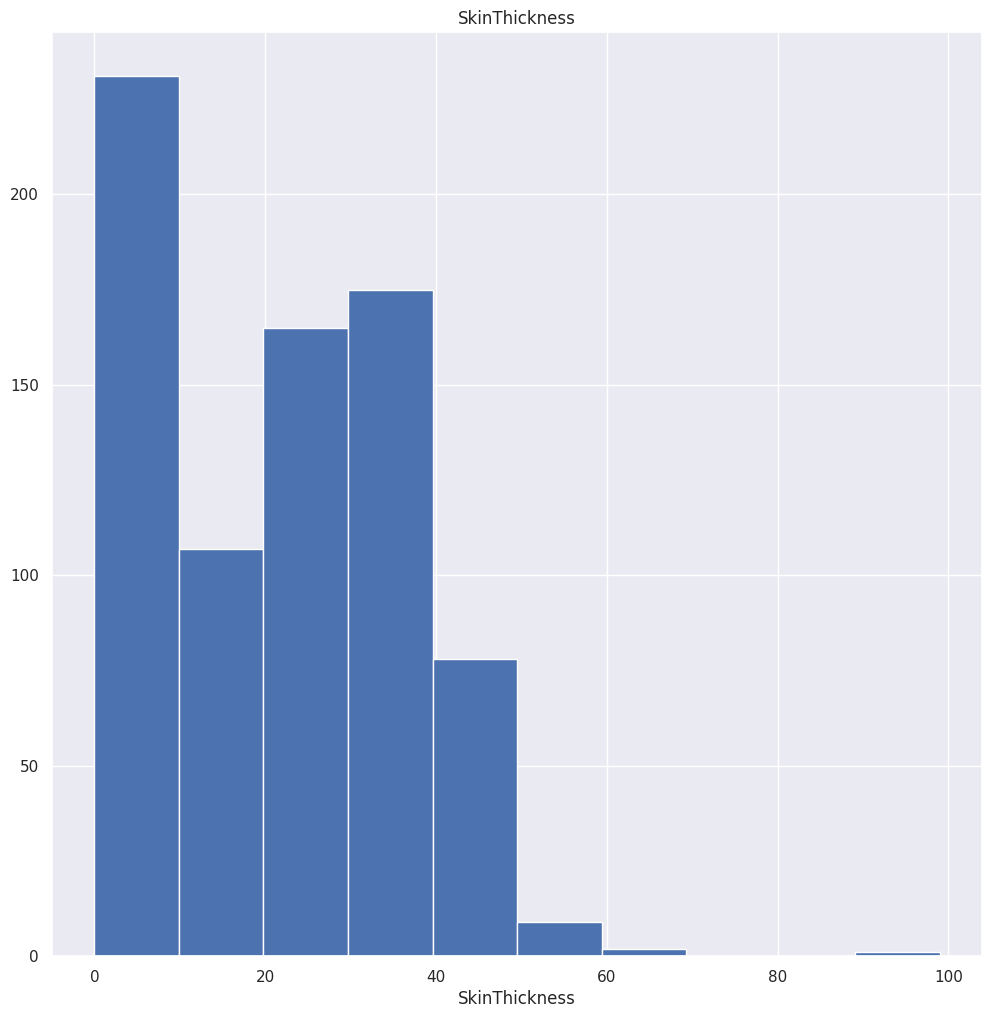

count   768.000
mean     79.799
std     115.244
min       0.000
5%        0.000
10%       0.000
20%       0.000
30%       0.000
40%       0.000
50%      30.500
60%      72.200
70%     106.000
80%     150.000
90%     210.000
95%     293.000
99%     519.900
max     846.000
Name: Insulin, dtype: float64


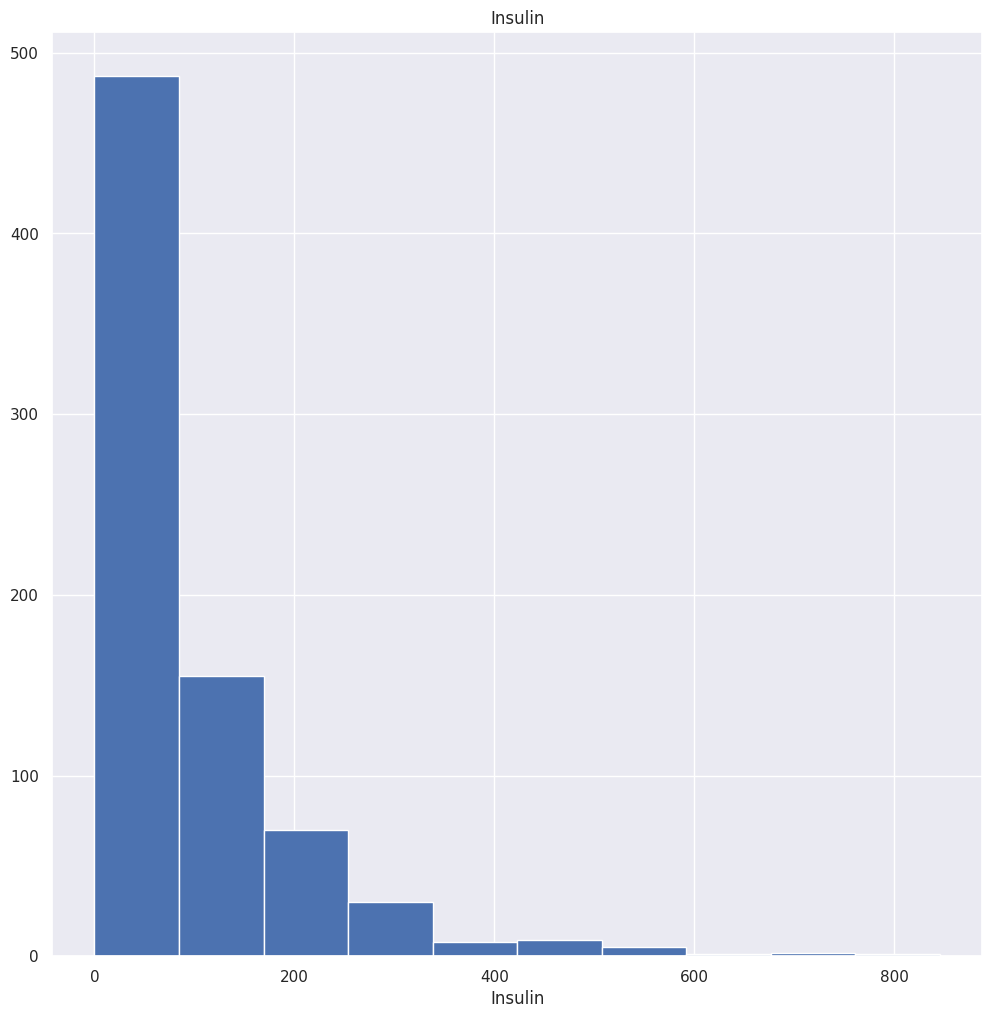

count   768.000
mean     31.993
std       7.884
min       0.000
5%       21.800
10%      23.600
20%      25.900
30%      28.200
40%      30.100
50%      32.000
60%      33.700
70%      35.490
80%      37.800
90%      41.500
95%      44.395
99%      50.759
max      67.100
Name: BMI, dtype: float64


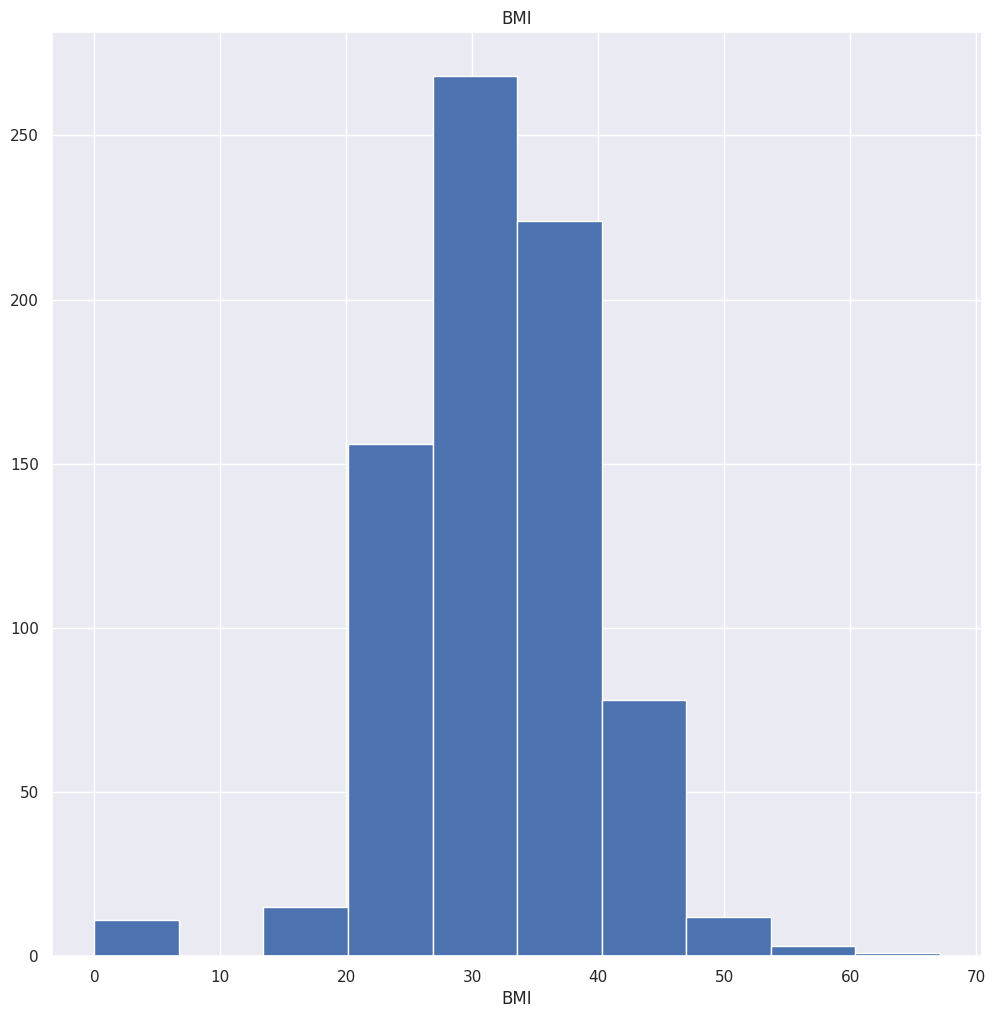

count   768.000
mean      0.472
std       0.331
min       0.078
5%        0.140
10%       0.165
20%       0.219
30%       0.259
40%       0.303
50%       0.372
60%       0.454
70%       0.564
80%       0.687
90%       0.879
95%       1.133
99%       1.698
max       2.420
Name: DiabetesPedigreeFunction, dtype: float64


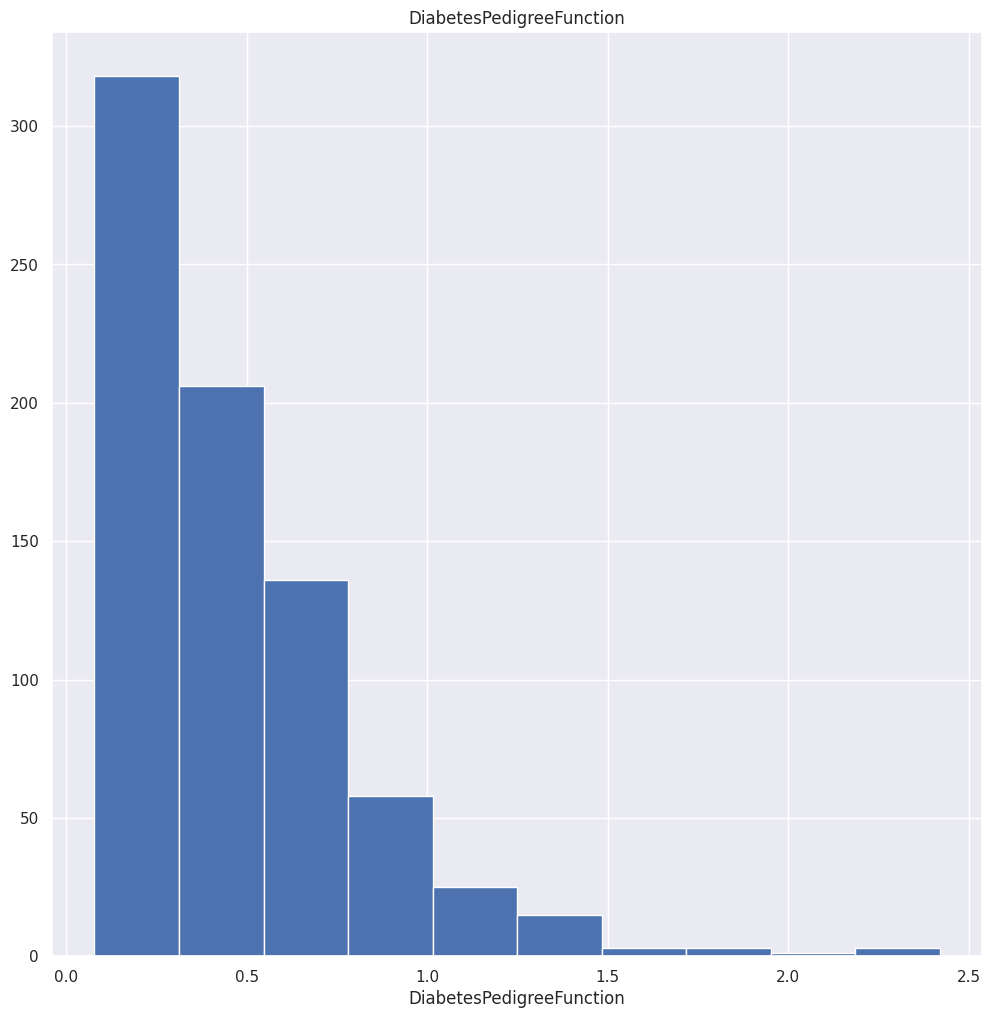

count   768.000
mean     33.241
std      11.760
min      21.000
5%       21.000
10%      22.000
20%      23.000
30%      25.000
40%      27.000
50%      29.000
60%      33.000
70%      38.000
80%      42.600
90%      51.000
95%      58.000
99%      67.000
max      81.000
Name: Age, dtype: float64


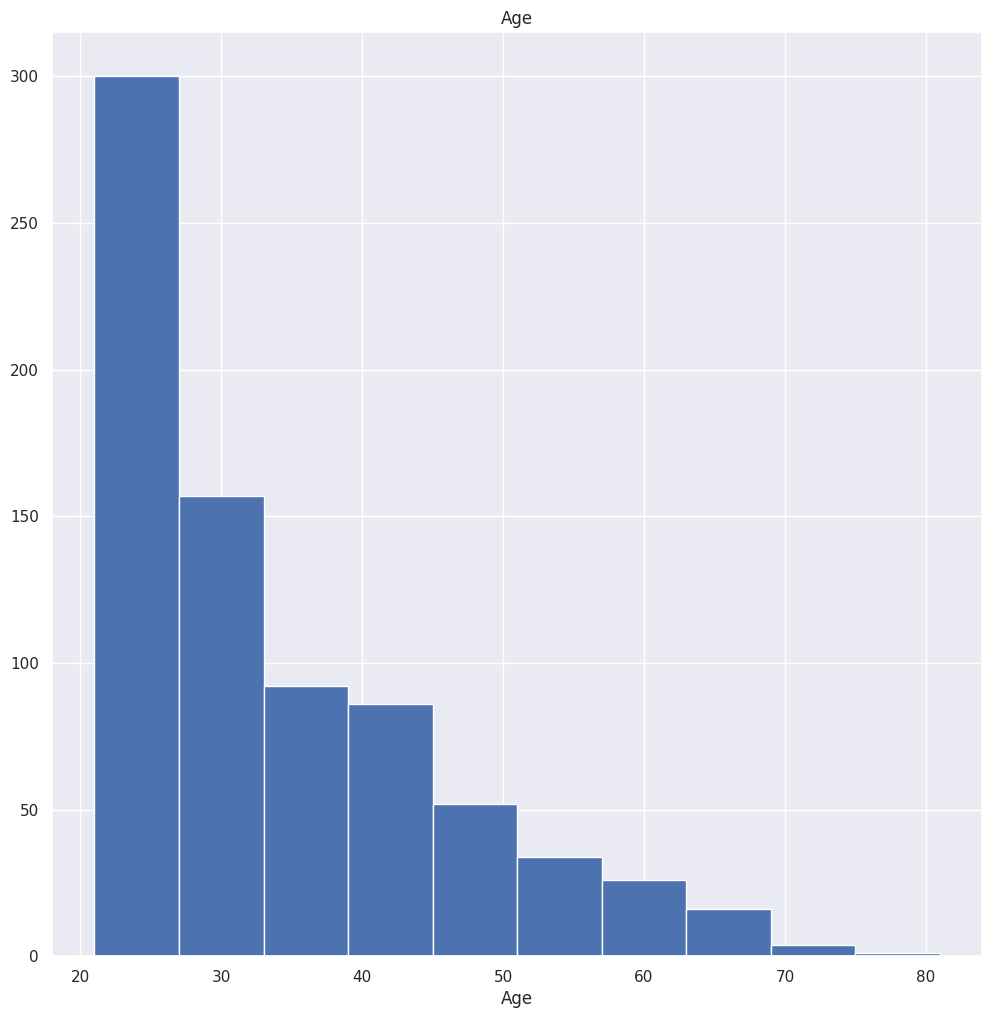

In [133]:
#Numerik değişkenlerin analizi.
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist()
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)

for col in num_cols:
  num_summary(df, col, plot=True)

In [134]:
#Hedef değişkenin numerik değişkenlere göre analizi.
def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")

for col in num_cols:
    target_summary_with_num(df, "Outcome", col)

         Pregnancies
Outcome             
0              3.298
1              4.866


         Glucose
Outcome         
0        109.980
1        141.257


         BloodPressure
Outcome               
0               68.184
1               70.825


         SkinThickness
Outcome               
0               19.664
1               22.164


         Insulin
Outcome         
0         68.792
1        100.336


           BMI
Outcome       
0       30.304
1       35.143


         DiabetesPedigreeFunction
Outcome                          
0                           0.430
1                           0.550


           Age
Outcome       
0       31.190
1       37.067




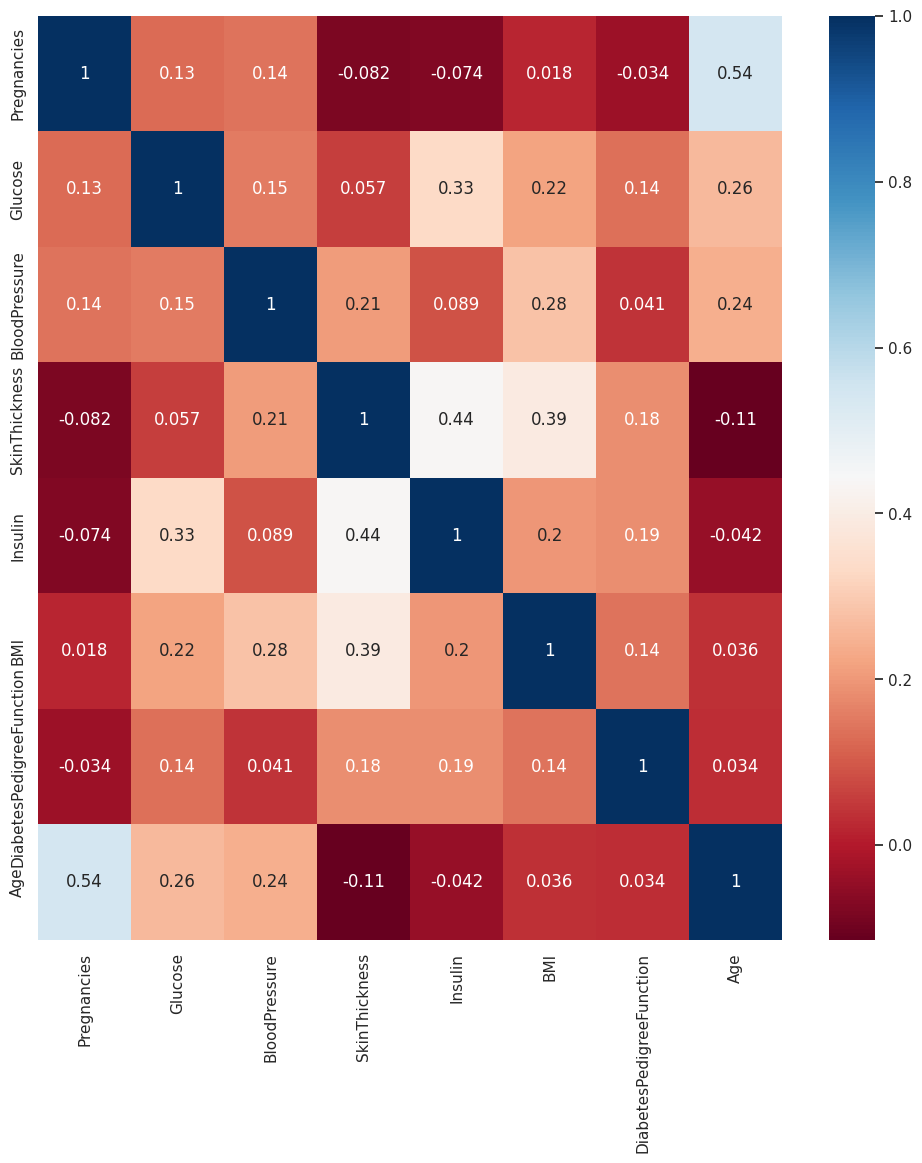

In [135]:
#Korelasyon analizi
corr = df[num_cols].corr()

sns.set(rc={'figure.figsize': (12, 12)})
sns.heatmap(corr, cmap="RdBu", annot=True)
plt.show()

Modelimizin hiçbir işlem görmeden önceki doğruluk oranı:
BASE MODEL

In [136]:
y = df["Outcome"]
X = df.drop(["Outcome"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=17)

rf_model = RandomForestClassifier(random_state=42).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
accuracy_score(y_pred, y_test)

0.7857142857142857

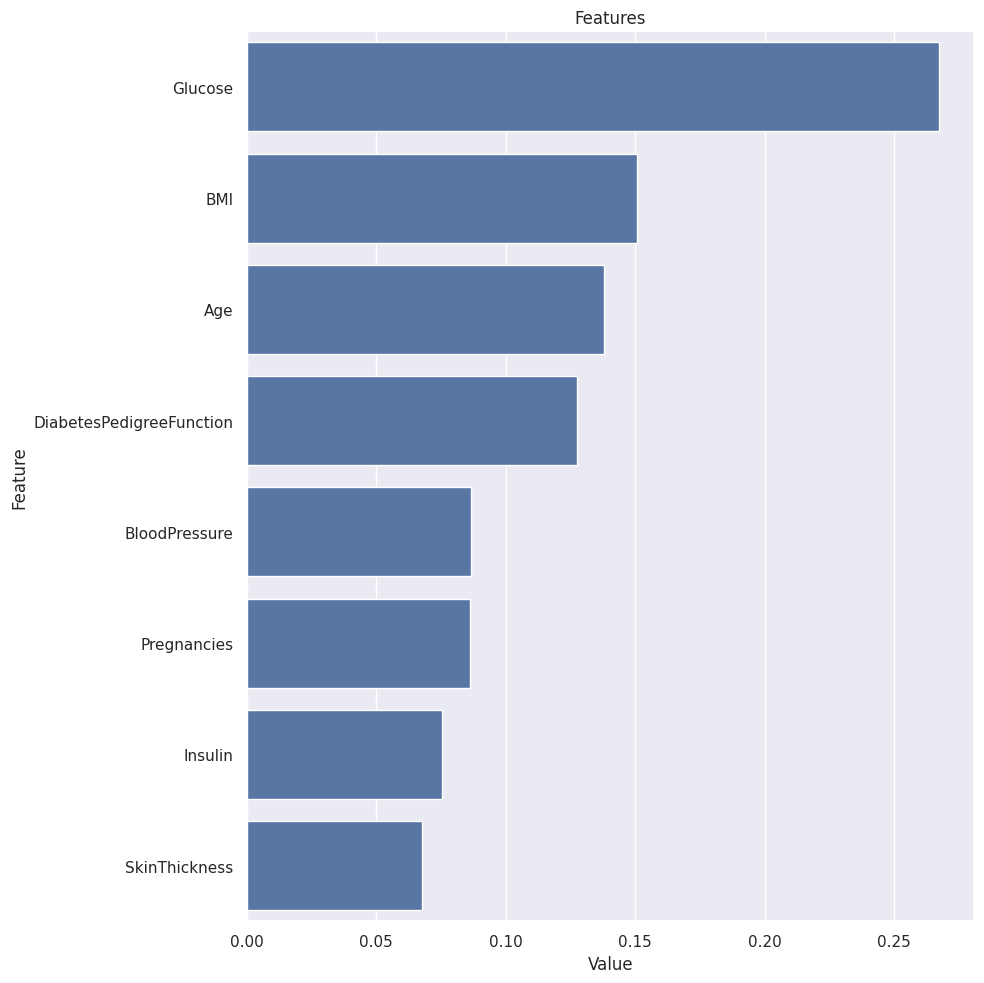

In [137]:
#Bu modeldeki en çok katkı veren değişkenler
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                      ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')


plot_importance(rf_model, X_train)

Bazı değerlerin içinde 0 vardır ve bu değerler 0 olamaz. Bunları öncelikle boş değer yapacağız.

In [138]:
#0 olan değerleri NAN'a çevirme
zero_col = [col for col in df.columns if (df[col].min() == 0 and col not in ["Pregnancies","Outcome"])]
zero_col

for col in zero_col:
  df[col] = np.where(df[col] == 0, np.nan, df[col])

In [139]:
#Eksik değer analizi
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")

    if na_name:
        return na_columns

na_columns = missing_values_table(df, na_name= True)

               n_miss  ratio
Insulin           374 48.700
SkinThickness     227 29.560
BloodPressure      35  4.560
BMI                11  1.430
Glucose             5  0.650


In [140]:
#Bağımlı değişkenin eksik değerlere göre analizi
def missing_vs_target(dataframe, target, na_columns):
    temp_df = dataframe.copy()
    for col in na_columns:
        temp_df[col + '_NA_FLAG'] = np.where(temp_df[col].isnull(), 1, 0)
    na_flags = temp_df.loc[:, temp_df.columns.str.contains("_NA_")].columns
    for col in na_flags:
        print(pd.DataFrame({"TARGET_MEAN": temp_df.groupby(col)[target].mean(),
                            "Count": temp_df.groupby(col)[target].count()}), end="\n\n\n")


missing_vs_target(df, "Outcome", na_columns)

                 TARGET_MEAN  Count
Glucose_NA_FLAG                    
0                      0.349    763
1                      0.400      5


                       TARGET_MEAN  Count
BloodPressure_NA_FLAG                    
0                            0.344    733
1                            0.457     35


                       TARGET_MEAN  Count
SkinThickness_NA_FLAG                    
0                            0.333    541
1                            0.388    227


                 TARGET_MEAN  Count
Insulin_NA_FLAG                    
0                      0.330    394
1                      0.369    374


             TARGET_MEAN  Count
BMI_NA_FLAG                    
0                  0.351    757
1                  0.182     11




In [141]:
# Boş olan değerleri median ile doldurur.
for col in zero_col:
  df.loc[df[col].isnull(), col] = df[col].median()

In [142]:
df.isnull().sum()

,0
Pregnancies,0
Glucose,0
BloodPressure,0
SkinThickness,0
Insulin,0
BMI,0
DiabetesPedigreeFunction,0
Age,0
Outcome,0


In [143]:
#Aykırı değerlerin hangi aralığa göre belirleneceğini gösteren fonksiyondur.
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

#Hangilerinin aykırı değer olarak kabul edildiğini "True" olarak gösterir.
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

#Baskılama yöntemi kullanacağız.
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

for col in num_cols:
    print(col, check_outlier(df, col))

Pregnancies True
Glucose False
BloodPressure True
SkinThickness True
Insulin True
BMI True
DiabetesPedigreeFunction True
Age True


In [144]:
#Baskılama yöntemi yapıyoruz.
for col in num_cols:
   replace_with_thresholds(df, col)

##Değişkenleri tekrar kontrol ediyoruz.
for col in num_cols:
    print(col, check_outlier(df, col))

Pregnancies False
Glucose False
BloodPressure False
SkinThickness False
Insulin False
BMI False
DiabetesPedigreeFunction False
Age False


<ipython-input-143-f9491084e57a>:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-6.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
<ipython-input-143-f9491084e57a>:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-1.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit


In [145]:
#Yeni değişkenler oluşturmak

#Yaş için 3 ayrı kategoriye bölüyoruz.
df.loc[(df['Age'] < 18), 'NEW_AGE'] = 'young'
df.loc[(df['Age'] >= 18) & (df['Age'] < 45), 'NEW_AGE'] = 'mature'
df.loc[(df['Age'] >= 45), 'NEW_AGE'] = 'senior'

#Vücut Kitle İndeksi değişkenini 4 ayrı sınıfa koyuyoruz.
df['NEW_BMI'] = pd.cut(x=df['BMI'], bins=[0, 18.5, 24.5, 29.5, 150],labels=["Underweight", "Healthy", "Overweight", "Obese"])

#Glukoz oranını 3 farklı sınıfa dönüştürüyoruz.
df["NEW_GLUCOSE"] = pd.cut(x=df["Glucose"], bins=[0, 140, 200, 300], labels=["Normal", "Prediabetes", "Diabetes"])

# Yaş ve beden kitle indeksini bir arada düşünerek kategorik değişken oluşturma 3 kırılım yakalandı
# BMI'sı 19dan küçük olanlar için yaş ile yeni sınıf
df.loc[(df["BMI"] < 19) & (df["Age"] < 18), "NEW_AGE_BMI"] = "underweightyoung"
df.loc[(df["BMI"] < 19) & ((df["Age"] >= 18) & (df["Age"] < 45)), "NEW_AGE_BMI"] = "underweightmature"
df.loc[(df["BMI"] < 19) & (df["Age"] >= 45), "NEW_AGE_BMI"] = "underweightsenior"

#BMI'sı 19-25 arası olan
df.loc[((df["BMI"] >= 19) & (df["BMI"] < 25)) & (df["Age"] < 18), "NEW_AGE_BMI"] = "healthyyoung"
df.loc[((df["BMI"] >= 19) & (df["BMI"] < 25)) & ((df["Age"] >= 18) & (df["Age"] < 45)), "NEW_AGE_BMI"] = "healthymature"
df.loc[((df["BMI"] >= 19) & (df["BMI"] < 25)) & (df["Age"] >= 18), "NEW_AGE_BMI"] = "healthysenior"

#25-30 arası
df.loc[((df["BMI"] >= 25) & (df["BMI"] < 30)) & (df["Age"] < 18), "NEW_AGE_BMI"] = "overweightyoung"
df.loc[((df["BMI"] >= 25) & (df["BMI"] < 30)) & ((df["Age"] >= 18) & (df["Age"] < 45)), "NEW_AGE_BMI"] = "overweightmature"
df.loc[((df["BMI"] >= 25) & (df["BMI"] < 30)) & (df["Age"] >= 45), "NEW_AGE_BMI"] = "overweightsenior"


df.loc[(df["BMI"] > 19) & (df["Age"] < 18), "NEW_AGE_BMI"] = "obeseyoung"
df.loc[(df["BMI"] > 19) & ((df["Age"] >= 18) & (df["Age"] < 45)), "NEW_AGE_BMI"] = "obesemature"
df.loc[(df["BMI"] > 19) & (df["Age"] >= 45), "NEW_AGE_BMI"] = "obesesenior"
df.loc


df["NEW_GLUCOSE*INSULIN"] = df["Glucose"] * df["Insulin"]

df["NEW_GLUCOSE*PREGNANCIES"] = df["Glucose"] * df["Pregnancies"]

cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 768
Variables: 15
cat_cols: 5
num_cols: 10
cat_but_car: 0
num_but_cat: 3


In [146]:
#Bütün değişken isimlerini büyütüyoruz.
df.columns = [col.upper() for col in df.columns ]
df.columns

Index(['PREGNANCIES', 'GLUCOSE', 'BLOODPRESSURE', 'SKINTHICKNESS', 'INSULIN', 'BMI', 'DIABETESPEDIGREEFUNCTION', 'AGE', 'OUTCOME', 'NEW_AGE', 'NEW_BMI', 'NEW_GLUCOSE', 'NEW_AGE_BMI', 'NEW_GLUCOSE*INSULIN', 'NEW_GLUCOSE*PREGNANCIES'], dtype='object')

In [147]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

binary_cols = [col for col in df.columns if df[col].dtypes == "O" and df[col].nunique() == 2]

for col in binary_cols:
    df = label_encoder(df, col)

Observations: 768
Variables: 15
cat_cols: 5
num_cols: 10
cat_but_car: 0
num_but_cat: 3


In [148]:
cat_cols = [col for col in cat_cols if col not in binary_cols and col not in ["OUTCOME"]]

def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

df = one_hot_encoder(df, cat_cols, drop_first=True)

In [149]:
#Verileri standartlaştırma
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

In [150]:
#Feature Engineering den sonraki model doğruluğu
y = df["OUTCOME"]
X = df.drop("OUTCOME", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=17)

rf_model = RandomForestClassifier(random_state=42).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
accuracy_score(y_pred, y_test)

0.8116883116883117

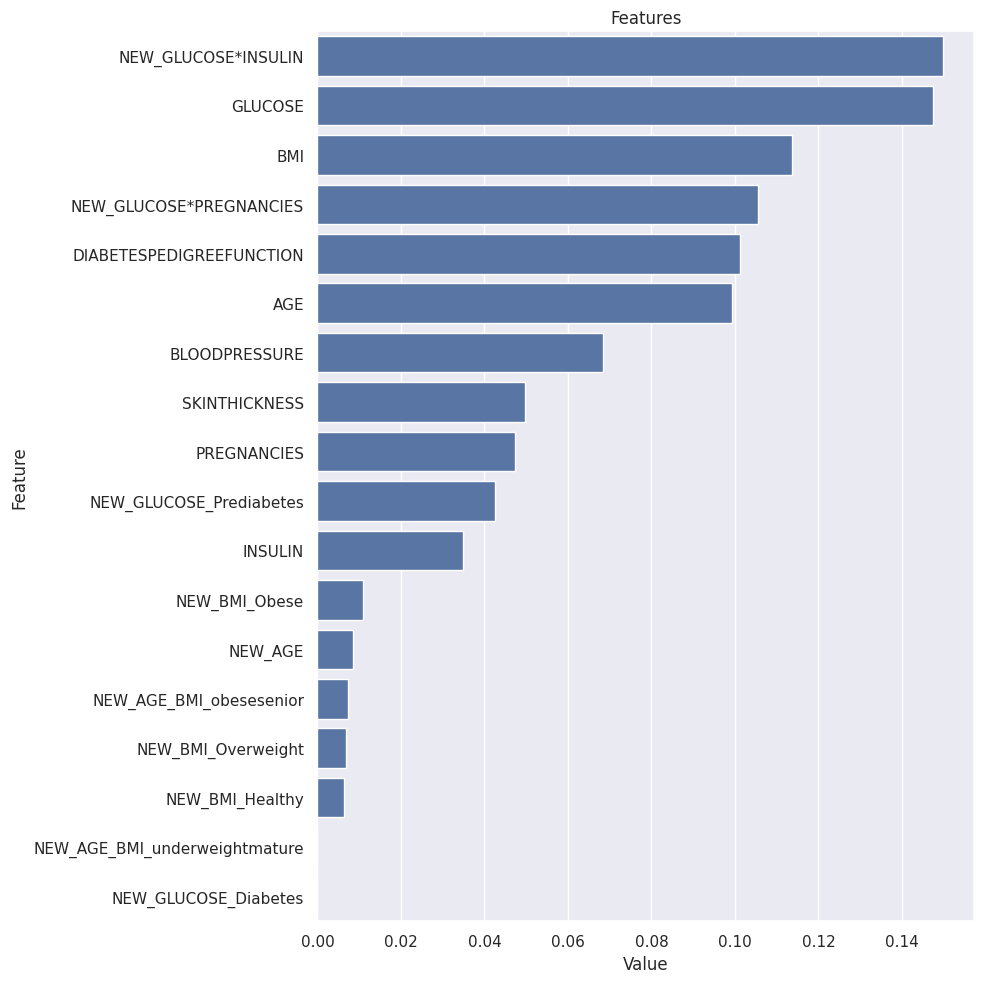

In [151]:
#Bu modeldeki en çok katkı veren değişkenler
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                      ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')


plot_importance(rf_model, X_train)